In [ ]:
%pip install --upgrade --quiet langchain langchain-neo4j langchain-openai langgraph

We default to OpenAI models in this guide.

In [3]:
import getpass
import os
api_base_url =  "http://127.0.0.1:8000/v1/"
model = "models/internlm2_5-7b-chat"
api_key = "my_key"

Next, we need to define Neo4j credentials.
Follow [these installation steps](https://neo4j.com/docs/operations-manual/current/installation/) to set up a Neo4j database.

In [4]:
os.environ["NEO4J_URI"] = "bolt://localhost:7687"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "123qwezxc"

The below example will create a connection with a Neo4j database and will populate it with example data about movies and their actors.

In [6]:
from langchain_neo4j import Neo4jGraph

enhanced_graph = Neo4jGraph(enhanced_schema=True)
print(enhanced_graph.schema)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The procedure has a deprecated field. ('config' used by 'apoc.meta.graphSample' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL apoc.meta.graphSample() YIELD nodes, relationships RETURN nodes, [rel in relationships | {name:apoc.any.property(rel, 'type'), count: apoc.any.property(rel, 'count')}] AS relationships"


Node properties:
- **安全管理**
  - `name`: STRING Example: "煤层气井钻井、压裂、排采、修井等施工方案"
- **法律法规**
  - `name`: STRING Example: "按照有关规定进行安全条件论证和安全预评价"
- **设备与工具**
  - `name`: STRING Example: "安全设施"
- **活动与作业**
  - `name`: STRING Example: "煤层气开采项目"
- **组织与人员**
  - `name`: STRING Example: "煤层气企业负责"
- **环境与条件**
  - `name`: STRING Example: "不能立即整改的"
- **Chunk**
  - `id`: STRING Available options: ['59ecb5a93f48af36ef23bddcd5ef1353']
  - `text`: STRING Available options: ['测井人员不得干什么?']
  - `question`: STRING Available options: ['测井人员不得干什么?']
  - `query`: STRING Available options: ["MATCH (person:组织与人员 {name: '测井人员'})-[:不得]->(activi"]
Relationship properties:

The relationships:
(:安全管理)-[:由]->(:组织与人员)
(:安全管理)-[:由]->(:安全管理)
(:安全管理)-[:应当]->(:组织与人员)
(:安全管理)-[:应当]->(:法律法规)
(:安全管理)-[:应当符合]->(:安全管理)
(:法律法规)-[:允许]->(:活动与作业)
(:设备与工具)-[:必须]->(:活动与作业)
(:设备与工具)-[:必须]->(:安全管理)
(:设备与工具)-[:属于]->(:活动与作业)
(:设备与工具)-[:应当]->(:安全管理)
(:设备与工具)-[:应当]->(:环境与条件)
(:设备与工具)-[:应当]->(:活动与作业)
(:设备与工具)-[:应当]->(:法律法规)
(:设备与工具)-[:应当]-

The `enhanced_schema` option enriches property information by including details such as minimum and maximum values for floats and dates, as well as example values for string properties. This additional context helps guide the LLM toward generating more accurate and effective queries.

Great! We've got a graph database that we can query. Now let's try hooking it up to an LLM.

## GraphQACypherChain

Let's use a simple out-of-the-box chain that takes a question, turns it into a Cypher query, executes the query, and uses the result to answer the original question.

![graph_chain.webp](../../static/img/graph_chain.webp)


LangChain comes with a built-in chain for this workflow that is designed to work with Neo4j: [GraphCypherQAChain](/docs/integrations/graphs/neo4j_cypher)

In [7]:
from langchain_neo4j import GraphCypherQAChain
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model_name=model,          # 使用你的模型
    temperature=0,           # 设置温度等其他参数
    openai_api_base=api_base_url,  # 传递 api_base_url
    openai_api_key=api_key,  # 传递 api_key
)
chain = GraphCypherQAChain.from_llm(
    graph=enhanced_graph, llm=llm, verbose=True, allow_dangerous_requests=True
)
response = chain.invoke({"query": "测井人员不得干什么?"})
response



> Entering new GraphCypherQAChain chain...
@@@@@ [HumanMessage(content='Task:Generate Cypher statement to query a graph database.\nInstructions:\nUse only the provided relationship types and properties in the schema.\nDo not use any other relationship types or properties that are not provided.\nSchema:\nNode properties are the following:\n安全管理 {name: STRING},法律法规 {name: STRING},设备与工具 {name: STRING},活动与作业 {name: STRING},组织与人员 {name: STRING},环境与条件 {name: STRING},Chunk {id: STRING, embedding: LIST, text: STRING, question: STRING, query: STRING}\nRelationship properties are the following:\n\nThe relationships are the following:\n(:安全管理)-[:由]->(:组织与人员),(:安全管理)-[:由]->(:安全管理),(:安全管理)-[:应当]->(:组织与人员),(:安全管理)-[:应当]->(:法律法规),(:安全管理)-[:应当符合]->(:安全管理),(:法律法规)-[:允许]->(:活动与作业),(:设备与工具)-[:必须]->(:活动与作业),(:设备与工具)-[:必须]->(:安全管理),(:设备与工具)-[:属于]->(:活动与作业),(:设备与工具)-[:应当]->(:安全管理),(:设备与工具)-[:应当]->(:环境与条件),(:设备与工具)-[:应当]->(:活动与作业),(:设备与工具)-[:应当]->(:法律法规),(:设备与工具)-[:应当]->(:设备与工具),(:设备与工具)-[:需要]->(:安全管理),(:设

{'query': '测井人员不得干什么?', 'result': '测井人员不得动用非本岗位的仪器设备，不得进行与测井无关的其他作业，也不得擅离职守。'}

## 使用LangGraph进行高级实现
虽然GraphCypherQAChain在快速演示方面很有效，但在生产环境中可能会面临挑战。过渡到LangGraph可以增强工作流程，但在生产中实现自然语言查询流仍然是一项复杂的任务。然而，有几种策略可以显著提高准确性和可靠性，我们将在下一步进行探索。

以下是我们将实现的可视化LangGraph流程：

In [8]:
from operator import add
from typing import Annotated, List

from typing_extensions import TypedDict


class InputState(TypedDict):
    question: str


class OverallState(TypedDict):
    question: str
    next_action: str
    cypher_statement: str
    cypher_errors: List[str]
    database_records: List[dict]
    steps: Annotated[List[str], add]


class OutputState(TypedDict):
    answer: str
    steps: List[str]
    cypher_statement: str

第一步是一个简单的步骤，我们验证问题是否与煤矿安全有关。如果没有，我们会通知用户我们无法回答任何其他问题。否则，我们继续进行 Cypher 生成步骤。

In [21]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate
from pydantic import BaseModel, Field

# 定义系统消息，描述智能助理的行为规则
guardrails_system = f"""
作为一名智能助理，你的主要目标是判断用户输入的问题是否与煤矿安全有关
如果问题与煤矿安全有关，则输出"coal"。否则，输出"end"。
为了做出这个决定，评估问题的内容，并确定它是否涉及任何安全管理、法律法规、设备与工具、活动与作业、组织与人员、环境与条件，
或相关主题。仅提供指定的输出："coal" 或 "end"。
用户提问：
{{question}}
"""

# 创建聊天模板，系统消息包含安全相关的决策逻辑，用户问题在"human"消息中
guardrails_prompt = ChatPromptTemplate(
    messages=[HumanMessagePromptTemplate.from_template(guardrails_system)],
    input_variables=["question"]
)

# 定义GuardrailsOutput类，用于存储模型输出的结果
class GuardrailsOutput(BaseModel):
    # 只有两个可能的输出：“coal”或“end”
    decision: Literal["coal", "end"] = Field(
        description="关于该问题是否与煤矿安全有关的决定"
    )

# 定义guardrails_chain，组合了聊天模板和结构化输出
# guardrails_chain = guardrails_prompt | llm
guardrails_chain = guardrails_prompt | llm.with_structured_output(GuardrailsOutput)

# guardrails函数是主要逻辑，用于根据用户问题做出判断
def guardrails(state: InputState) -> OverallState:
    """
    决定问题是否与煤矿安全有关。
    """
    # 调用guardrails_chain，传入问题，返回结构化输出
    guardrails_output = guardrails_chain.invoke({"question": state.get("question")})
    
    # 如果问题与煤矿安全无关，设置database_records为提示信息
    database_records = None
    if guardrails_output.decision == "end":
        database_records = "这个问题与煤矿安全无关。因此，我无法回答这个问题。"

    # 返回包含下一步动作、数据库记录和处理步骤的结果
    return {
        "next_action": guardrails_output.decision,  # 根据决策返回“coal”或“end”
        "database_records": database_records,  # 如果是“end”，返回相关提示信息
        "steps": ["guardrail"],  # 当前处理步骤
    }


### Few-shot 提示

将自然语言转换为准确的查询具有挑战性。增强此过程的一种方法是提供相关的 
few-shot 示例来指导 LLM 生成查询。为此，我们将使用 动态选择最相关的示例。

In [50]:
from langchain_core.example_selectors import SemanticSimilarityExampleSelector
from langchain_neo4j import Neo4jVector
# from langchain_openai import OpenAIEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings
examples = [
    {
        "question": "煤矿测井人员不得干什么?",
        "query": "MATCH (person:组织与人员 {name: '测井人员'})-[:不得]->(activity:活动与作业) RETURN person.name AS person_name, activity.name AS activity_name",
    },
   
    
]
embed_model = HuggingFaceEmbeddings(
#指定了一个预训练的sentence-transformer模型的路径
    model_name="/root/model/sentence-transformer"
)
example_selector = SemanticSimilarityExampleSelector.from_examples(
    examples, embed_model, Neo4jVector, k=5, input_keys=["question"]
)

### text2cypher
接下来，我们实现 Cypher 生成链，也称为 text2cypher。
该提示包括增强的图形架构、动态选择的少数样本示例和用户的问题。这种组合允许生成 Cypher 查询以从数据库中检索相关信息。

In [11]:
from langchain_core.output_parsers import StrOutputParser

text2cypher_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            (
                "Given an input question, convert it to a Cypher query. No pre-amble."
                "Do not wrap the response in any backticks or anything else. Respond with a Cypher statement only!"
            ),
        ),
        (
            "human",
            (
                """You are a Neo4j expert. Given an input question, create a syntactically correct Cypher query to run.
Do not wrap the response in any backticks or anything else. Respond with a Cypher statement only!
Here is the schema information
{schema}

Below are a number of examples of questions and their corresponding Cypher queries.

{fewshot_examples}

User input: {question}
Cypher query:"""
            ),
        ),
    ]
)

text2cypher_chain = text2cypher_prompt | llm | StrOutputParser()


def generate_cypher(state: OverallState) -> OverallState:
    """
    Generates a cypher statement based on the provided schema and user input
    """
    NL = "\n"
    fewshot_examples = (NL * 2).join(
        [
            f"Question: {el['question']}{NL}Cypher:{el['query']}"
            for el in example_selector.select_examples(
                {"question": state.get("question")}
            )
        ]
    )
    generated_cypher = text2cypher_chain.invoke(
        {
            "question": state.get("question"),
            "fewshot_examples": fewshot_examples,
            "schema": enhanced_graph.schema,
        }
    )
    return {"cypher_statement": generated_cypher, "steps": ["generate_cypher"]}

### 查询验证

下一步是验证生成的 Cypher 语句并确保所有属性值都准确无误。

In [12]:
from typing import List, Optional

validate_cypher_system = """
You are a Cypher expert reviewing a statement written by a junior developer.
"""

validate_cypher_user = """You must check the following:
* Are there any syntax errors in the Cypher statement?
* Are there any missing or undefined variables in the Cypher statement?
* Are any node labels missing from the schema?
* Are any relationship types missing from the schema?
* Are any of the properties not included in the schema?
* Does the Cypher statement include enough information to answer the question?

Examples of good errors:
* Label (:Foo) does not exist, did you mean (:Bar)?
* Property bar does not exist for label Foo, did you mean baz?
* Relationship FOO does not exist, did you mean FOO_BAR?

Schema:
{schema}

The question is:
{question}

The Cypher statement is:
{cypher}

Make sure you don't make any mistakes!"""

validate_cypher_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            validate_cypher_system,
        ),
        (
            "human",
            (validate_cypher_user),
        ),
    ]
)


class Property(BaseModel):
    """
    Represents a filter condition based on a specific node property in a graph in a Cypher statement.
    """

    node_label: str = Field(
        description="The label of the node to which this property belongs."
    )
    property_key: str = Field(description="The key of the property being filtered.")
    property_value: str = Field(
        description="The value that the property is being matched against."
    )


class ValidateCypherOutput(BaseModel):
    """
    Represents the validation result of a Cypher query's output,
    including any errors and applied filters.
    """

    errors: Optional[List[str]] = Field(
        description="A list of syntax or semantical errors in the Cypher statement. Always explain the discrepancy between schema and Cypher statement"
    )
    filters: Optional[List[Property]] = Field(
        description="A list of property-based filters applied in the Cypher statement."
    )


validate_cypher_chain = validate_cypher_prompt | llm.with_structured_output(
    ValidateCypherOutput
)

### CypherQueryCorrector
LLM 经常难以正确确定生成的 Cypher 语句中的关系方向。
由于我们可以访问架构，因此可以使用 CypherQueryCorrector 确定性地更正这些方向。

In [13]:
from langchain_neo4j.chains.graph_qa.cypher_utils import CypherQueryCorrector, Schema

# Cypher query corrector is experimental
corrector_schema = [
    Schema(el["start"], el["type"], el["end"])
    for el in enhanced_graph.structured_schema.get("relationships")
]
cypher_query_corrector = CypherQueryCorrector(corrector_schema)

现在我们可以实现 Cypher 验证步骤。首先，我们使用该方法检测任何语法错误。
接下来，我们利用 LLM 来识别潜在问题并提取用于筛选的属性。对于字符串属性，我们使用一个简单的子句针对数据库验证它们。EXPLAINCONTAINS
根据验证结果，该过程可以采用以下路径：
如果值映射失败，我们将结束对话并通知用户我们无法识别特定属性值
如果发现错误，我们将路由查询以进行更正。
如果未检测到问题，我们将继续执行 Cypher 执行步骤。

In [14]:
from neo4j.exceptions import CypherSyntaxError


def validate_cypher(state: OverallState) -> OverallState:
    """
    Validates the Cypher statements and maps any property values to the database.
    """
    errors = []
    mapping_errors = []
    # Check for syntax errors
    try:
        enhanced_graph.query(f"EXPLAIN {state.get('cypher_statement')}")
    except CypherSyntaxError as e:
        errors.append(e.message)
    # Experimental feature for correcting relationship directions
    corrected_cypher = cypher_query_corrector(state.get("cypher_statement"))
    if not corrected_cypher:
        errors.append("The generated Cypher statement doesn't fit the graph schema")
    if not corrected_cypher == state.get("cypher_statement"):
        print("Relationship direction was corrected")
    # Use LLM to find additional potential errors and get the mapping for values
    llm_output = validate_cypher_chain.invoke(
        {
            "question": state.get("question"),
            "schema": enhanced_graph.schema,
            "cypher": state.get("cypher_statement"),
        }
    )
    if llm_output.errors:
        errors.extend(llm_output.errors)
    if llm_output.filters:
        for filter in llm_output.filters:
            # Do mapping only for string values
            if (
                not [
                    prop
                    for prop in enhanced_graph.structured_schema["node_props"][
                        filter.node_label
                    ]
                    if prop["property"] == filter.property_key
                ][0]["type"]
                == "STRING"
            ):
                continue
            mapping = enhanced_graph.query(
                f"MATCH (n:{filter.node_label}) WHERE toLower(n.`{filter.property_key}`) = toLower($value) RETURN 'yes' LIMIT 1",
                {"value": filter.property_value},
            )
            if not mapping:
                print(
                    f"Missing value mapping for {filter.node_label} on property {filter.property_key} with value {filter.property_value}"
                )
                mapping_errors.append(
                    f"Missing value mapping for {filter.node_label} on property {filter.property_key} with value {filter.property_value}"
                )
    if mapping_errors:
        next_action = "end"
    elif errors:
        next_action = "correct_cypher"
    else:
        next_action = "execute_cypher"

    return {
        "next_action": next_action,
        "cypher_statement": corrected_cypher,
        "cypher_errors": errors,
        "steps": ["validate_cypher"],
    }

The Cypher correction step takes the existing Cypher statement, any identified errors, and the original question to generate a corrected version of the query.

In [15]:
correct_cypher_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            (
                "You are a Cypher expert reviewing a statement written by a junior developer. "
                "You need to correct the Cypher statement based on the provided errors. No pre-amble."
                "Do not wrap the response in any backticks or anything else. Respond with a Cypher statement only!"
            ),
        ),
        (
            "human",
            (
                """Check for invalid syntax or semantics and return a corrected Cypher statement.

Schema:
{schema}

Note: Do not include any explanations or apologies in your responses.
Do not wrap the response in any backticks or anything else.
Respond with a Cypher statement only!

Do not respond to any questions that might ask anything else than for you to construct a Cypher statement.

The question is:
{question}

The Cypher statement is:
{cypher}

The errors are:
{errors}

Corrected Cypher statement: """
            ),
        ),
    ]
)

correct_cypher_chain = correct_cypher_prompt | llm | StrOutputParser()


def correct_cypher(state: OverallState) -> OverallState:
    """
    Correct the Cypher statement based on the provided errors.
    """
    corrected_cypher = correct_cypher_chain.invoke(
        {
            "question": state.get("question"),
            "errors": state.get("cypher_errors"),
            "cypher": state.get("cypher_statement"),
            "schema": enhanced_graph.schema,
        }
    )

    return {
        "next_action": "validate_cypher",
        "cypher_statement": corrected_cypher,
        "steps": ["correct_cypher"],
    }

We need to add a step that executes the given Cypher statement. If no results are returned, we should explicitly handle this scenario, as leaving the context empty can sometimes lead to LLM hallucinations.

In [16]:
no_results = "I couldn't find any relevant information in the database"


def execute_cypher(state: OverallState) -> OverallState:
    """
    Executes the given Cypher statement.
    """

    records = enhanced_graph.query(state.get("cypher_statement"))
    return {
        "database_records": records if records else no_results,
        "next_action": "end",
        "steps": ["execute_cypher"],
    }

The final step is to generate the answer. This involves combining the initial question with the database output to produce a relevant response.

In [17]:
generate_final_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant",
        ),
        (
            "human",
            (
                """Use the following results retrieved from a database to provide
a succinct, definitive answer to the user's question.

Respond as if you are answering the question directly.

Results: {results}
Question: {question}"""
            ),
        ),
    ]
)

generate_final_chain = generate_final_prompt | llm | StrOutputParser()


def generate_final_answer(state: OverallState) -> OutputState:
    """
    Decides if the question is related to movies.
    """
    final_answer = generate_final_chain.invoke(
        {"question": state.get("question"), "results": state.get("database_records")}
    )
    return {"answer": final_answer, "steps": ["generate_final_answer"]}

Next, we will implement the LangGraph workflow, starting with defining the conditional edge functions.

In [46]:
def guardrails_condition(
    state: OverallState,
) -> Literal["generate_cypher", "generate_final_answer"]:
    if state.get("next_action") == "end":
        return "generate_final_answer"
    elif state.get("next_action") == "coal":
        return "generate_cypher"


def validate_cypher_condition(
    state: OverallState,
) -> Literal["generate_final_answer", "correct_cypher", "execute_cypher"]:
    if state.get("next_action") == "end":
        return "generate_final_answer"
    elif state.get("next_action") == "correct_cypher":
        return "correct_cypher"
    elif state.get("next_action") == "execute_cypher":
        return "execute_cypher"

Let's put it all together now.

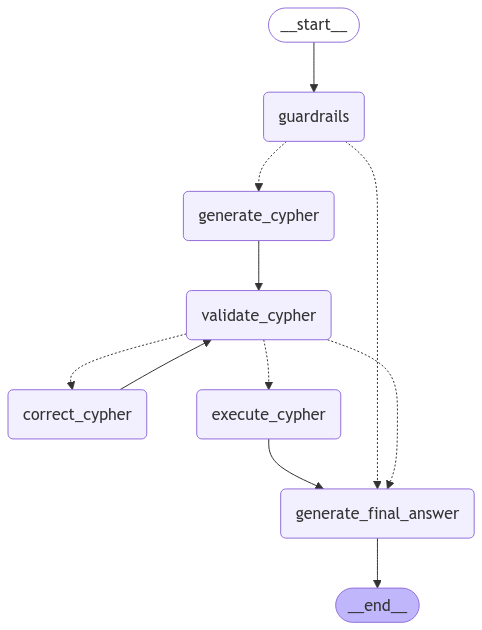

In [51]:
from IPython.display import Image, display
from langgraph.graph import END, START, StateGraph

langgraph = StateGraph(OverallState, input=InputState, output=OutputState)
langgraph.add_node(guardrails)
langgraph.add_node(generate_cypher)
langgraph.add_node(validate_cypher)
langgraph.add_node(correct_cypher)
langgraph.add_node(execute_cypher)
langgraph.add_node(generate_final_answer)

langgraph.add_edge(START, "guardrails")
langgraph.add_conditional_edges(
    "guardrails",
    guardrails_condition,
)
langgraph.add_edge("generate_cypher", "validate_cypher")
langgraph.add_conditional_edges(
    "validate_cypher",
    validate_cypher_condition,
)
langgraph.add_edge("execute_cypher", "generate_final_answer")
langgraph.add_edge("correct_cypher", "validate_cypher")
langgraph.add_edge("generate_final_answer", END)

# langgraph.add_edge(START, "guardrails")
# langgraph.add_edge("guardrails", "generate_cypher")
# langgraph.add_edge("generate_cypher", "validate_cypher")
# langgraph.add_edge("validate_cypher", END)
langgraph = langgraph.compile()

# View
display(Image(langgraph.get_graph().draw_mermaid_png()))

问一些无关问题

In [24]:
langgraph.invoke({"question": "What's the weather in Spain?"})

@@@@@ [HumanMessage(content='\n作为一名智能助理，你的主要目标是决定一个给定的问题是否与煤矿安全有关。\n如果问题与煤矿安全有关，则输出"coal"。否则，输出"end"。\n为了做出这个决定，评估问题的内容，并确定它是否涉及任何安全管理、法律法规、设备与工具、活动与作业、组织与人员、环境与条件，\n或相关主题。仅提供指定的输出："coal" 或 "end"。\n用户提问：\nWhat\'s the weather in Spain?\n', additional_kwargs={}, response_metadata={})]
@@@ {'id': 'chatcmpl-79a6e29b3b0749989e8951b933bf2c38', 'choices': [{'finish_reason': 'stop', 'index': 0, 'logprobs': None, 'message': {'content': '', 'refusal': None, 'role': 'assistant', 'audio': None, 'function_call': None, 'tool_calls': [{'id': 'chatcmpl-tool-402c272ac3ef4ccc9b8d7d1d9473ba01', 'function': {'arguments': '{ "decision": "end" }', 'name': 'GuardrailsOutput'}, 'type': 'function'}]}, 'stop_reason': None}], 'created': 1735875127, 'model': 'models/internlm2_5-7b-chat', 'object': 'chat.completion', 'service_tier': None, 'system_fingerprint': None, 'usage': {'completion_tokens': 10, 'prompt_tokens': 192, 'total_tokens': 202, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'prom

{'answer': "I'm sorry, but the results provided are unrelated to the weather in Spain. Therefore, I cannot answer the question.",
 'steps': ['guardrail', 'generate_final_answer']}

一些相关问题

In [55]:
langgraph.invoke({"question": "监理单位应当遵守什么法律法规?"})

@@@@@ [HumanMessage(content='\n作为一名智能助理，你的主要目标是决定一个给定的问题是否与煤矿安全有关。\n如果问题与煤矿安全有关，则输出"coal"。否则，输出"end"。\n为了做出这个决定，评估问题的内容，并确定它是否涉及任何安全管理、法律法规、设备与工具、活动与作业、组织与人员、环境与条件，\n或相关主题。仅提供指定的输出："coal" 或 "end"。\n用户提问：\n监理单位应当遵守什么法律法规?\n', additional_kwargs={}, response_metadata={})]
@@@ {'id': 'chatcmpl-bcec347a49c643e487ce8247738564fd', 'choices': [{'finish_reason': 'stop', 'index': 0, 'logprobs': None, 'message': {'content': '', 'refusal': None, 'role': 'assistant', 'audio': None, 'function_call': None, 'tool_calls': [{'id': 'chatcmpl-tool-4b5df301fe4f48ddb3ee9686b17c88c7', 'function': {'arguments': '{ "decision": "end" }', 'name': 'GuardrailsOutput'}, 'type': 'function'}]}, 'stop_reason': None}], 'created': 1735897675, 'model': 'models/internlm2_5-7b-chat', 'object': 'chat.completion', 'service_tier': None, 'system_fingerprint': None, 'usage': {'completion_tokens': 10, 'prompt_tokens': 192, 'total_tokens': 202, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'prompt_logprobs': 

{'answer': '监理单位应当遵守以下法律法规：\n\n1. 《中华人民共和国建筑法》：该法规定了建筑活动的基本原则和要求，包括监理单位的职责和义务。\n\n2. 《中华人民共和国建设工程质量管理条例》：该条例明确了建设工程质量管理的基本要求，包括监理单位在质量控制中的作用。\n\n3. 《中华人民共和国建设工程安全生产管理条例》：该条例规定了建设工程安全生产的基本要求，包括监理单位在安全生产管理中的职责。\n\n4. 《中华人民共和国合同法》：该法规定了建设工程合同的基本原则和要求，包括监理单位在合同履行中的义务。\n\n5. 《中华人民共和国招标投标法》：该法规定了建设工程招标投标的基本原则和要求，包括监理单位在招标投标活动中的职责。\n\n6. 《中华人民共和国环境保护法》：该法规定了环境保护的基本原则和要求，包括监理单位在环境保护中的职责。\n\n7. 《中华人民共和国劳动法》：该法规定了劳动保护的基本原则和要求，包括监理单位在劳动保护中的职责。\n\n8. 《中华人民共和国消防法》：该法规定了消防安全的基本原则和要求，包括监理单位在消防安全管理中的职责。\n\n9. 《中华人民共和国城市规划法》：该法规定了城市规划的基本原则和要求，包括监理单位在城市规划中的职责。\n\n10. 《中华人民共和国土地管理法》：该法规定了土地管理的基本原则和要求，包括监理单位在土地管理中的职责。\n\n以上法律法规是监理单位在建设工程活动中应当遵守的主要法律法规。',
 'steps': ['guardrail', 'generate_final_answer']}

### Next steps

For other graph techniques like this and more check out:

* [Semantic layer](/docs/how_to/graph_semantic): Techniques for implementing semantic layers.
* [Constructing graphs](/docs/how_to/graph_constructing): Techniques for constructing knowledge graphs.